In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import os
import seaborn as sns
from IPython.display import display, HTML
import numpy as np

In [ ]:
members_file_path = '/drive-download-20241120T092822Z-001/members.csv'
downloads_file_path = '/drive-download-20241120T092822Z-001/downloads.csv'

members_df = pd.read_csv(members_file_path)

downloads_df = pd.read_csv(downloads_file_path)


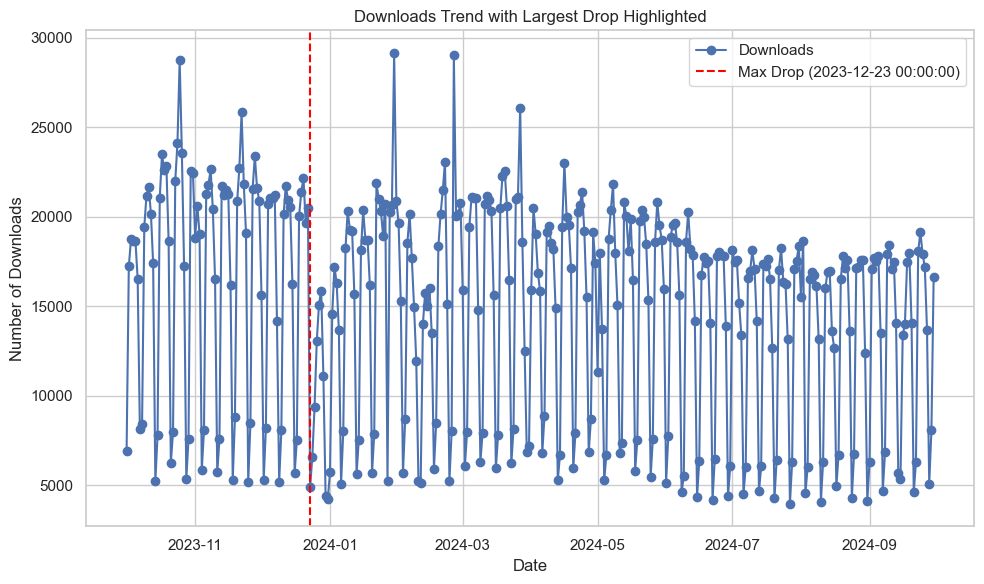

{'largest_drop_date': Timestamp('2023-12-23 00:00:00'),
 'largest_drop_percentage': '76.07%'}

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

downloads_df['date_download'] = pd.to_datetime(downloads_df['date_download'])

daily_downloads = downloads_df.resample('D', on='date_download').size()

percentage_changes = daily_downloads.pct_change().fillna(0)

largest_drop_date = percentage_changes.idxmin()
largest_drop_percentage = percentage_changes.min() * 100

plt.figure(figsize=(10, 6))
plt.plot(daily_downloads.index, daily_downloads.values, label="Downloads", marker='o')
plt.axvline(largest_drop_date, color='red', linestyle='--', label=f"Max Drop ({largest_drop_date})")
plt.title("Downloads Trend with Largest Drop Highlighted")
plt.xlabel("Date")
plt.ylabel("Number of Downloads")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

result = {
    "largest_drop_date": largest_drop_date,
    "largest_drop_percentage": f"{largest_drop_percentage:.2f}%"
}
result


### When did the drop occur, if any do you think the CEO was referring to?
The drop took place on December 23, 2023.

### How can we identify the drop?
The drop is identified by examining the daily downloads trend and calculating the percentage change between each consecutive days. This analysis reveals a very sharp decline in downloads on the specified date.

### How serious is the drop?
The drop is significant, reflecting a 76.07% decrease compared to the previous day. This reduction could have a notable impact on user engagement.

In [ ]:
merged_df = downloads_df.merge(members_df, on='uid', how='left')

drop_date = largest_drop_date.date()
drop_day_data = merged_df[merged_df['date_download'].dt.date == drop_date]

previous_day = (largest_drop_date - pd.Timedelta(days=1)).date()
prev_day_data = merged_df[merged_df['date_download'].dt.date == previous_day]

drop_day_country_counts = drop_day_data['country'].value_counts()
prev_day_country_counts = prev_day_data['country'].value_counts()

country_drops = drop_day_country_counts.subtract(prev_day_country_counts, fill_value=0)

sorted_country_drops = country_drops.sort_values()

user_downloads_on_drop = drop_day_data['uid'].value_counts()

result = {
    "most_affected_country": sorted_country_drops.idxmin(),
    "user_contribution_on_drop_date": user_downloads_on_drop.describe().to_dict()
}
result


{'most_affected_country': 'CN',
 'user_contribution_on_drop_date': {'count': 973.0,
  'mean': 5.044193216855088,
  'std': 14.914954370708758,
  'min': 1.0,
  '25%': 1.0,
  '50%': 2.0,
  '75%': 4.0,
  'max': 244.0}}

### Is the drop attributed to certain countries and/or users? 
The most affected country attributed to the drop is China (CN)

### If so, how can we identify them?
User Contributions on Largest Drop Date:

The total number users is 973. The average downloads per user is 5 users. Maximum downloads by a single user on that day is 244. The majority of users downloaded only a small number of items, as indicated by the Q1 and Q2 both at 1 and 2 downloads respectively.

In [45]:
user_contribution_distribution = user_downloads_on_drop.describe()

top_10_percent_threshold = user_downloads_on_drop.quantile(0.85)
top_users_downloads = user_downloads_on_drop[user_downloads_on_drop >= top_10_percent_threshold].sum()
total_downloads_on_drop_date = user_downloads_on_drop.sum()
top_10_percent_contribution = (top_users_downloads / total_downloads_on_drop_date) * 100

{
    "top_10_percent_contribution": f"{top_10_percent_contribution:.2f}%"
}


{'top_10_percent_contribution': '67.87%'}

### Is the drop coming from many small downloaders, or coming from few major downloaders?
The drop is primarily coming from a few major downloaders since the top 15% of users contributed 67.87% of the downloads on the drop date.

In [60]:
import holidays

malaysia_holidays = holidays.Malaysia(years=2023)

public_holidays = [str(holiday) for holiday in malaysia_holidays.keys()]
print(public_holidays)


['2023-01-22', '2023-01-23', '2023-05-04', '2023-05-01', '2023-06-05', '2023-08-31', '2023-09-16', '2023-12-25', '2023-07-19', '2023-09-28', '2023-04-22', '2023-04-23', '2023-06-29', '2023-04-21', '2023-01-24', '2023-04-24']


In [ ]:
is_public_holiday = drop_date.strftime('%Y-%m-%d') in public_holidays
if is_public_holiday:
    print(f"The drop occurred on a public holiday: {drop_date.strftime('%Y-%m-%d')}")
else:
    print(f"The drop did not occur on a public holiday.")

The drop did not occur on a public holiday.


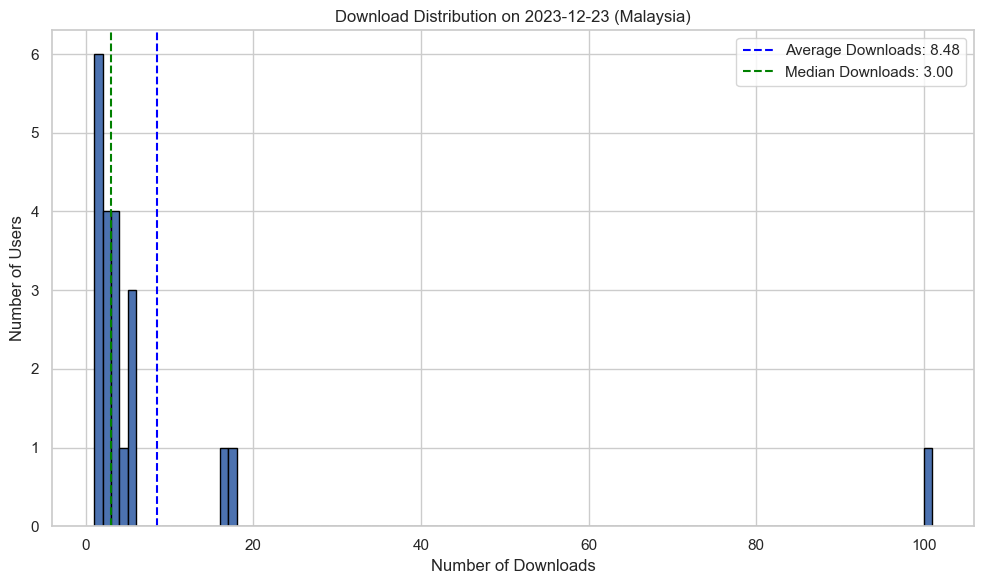

The drop did not occur on a public holiday: 2023-12-23


In [69]:
drop_date = pd.to_datetime(drop_date).date()  

malaysia_drop_data = merged_df[(merged_df['country'] == 'MY') & 
                                (merged_df['date_download'].dt.date == drop_date)]

downloads_by_user_on_drop = malaysia_drop_data.groupby('uid').size()

downloads_by_user_on_drop = downloads_by_user_on_drop.dropna()

plt.figure(figsize=(10, 6))

if not downloads_by_user_on_drop.empty:
    max_downloads = int(downloads_by_user_on_drop.max()) 
    plt.hist(downloads_by_user_on_drop, bins=range(1, max_downloads + 2), edgecolor='black')

    plt.title(f"Download Distribution on {drop_date} (Malaysia)")
    average_downloads = downloads_by_user_on_drop.mean()
    median_downloads = downloads_by_user_on_drop.median()
    plt.axvline(average_downloads, color='blue', linestyle='dashed', label=f"Average Downloads: {average_downloads:.2f}")
    plt.axvline(median_downloads, color='green', linestyle='dashed', label=f"Median Downloads: {median_downloads:.2f}")

    plt.xlabel("Number of Downloads")
    plt.ylabel("Number of Users")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"No data available for the public holiday: {drop_date}")

is_public_holiday = drop_date.strftime('%Y-%m-%d') in public_holidays
if is_public_holiday:
    print(f"The drop occurred on a public holiday: {drop_date.strftime('%Y-%m-%d')}")
else:
    print(f"The drop did not occur on a public holiday: {drop_date.strftime('%Y-%m-%d')}")

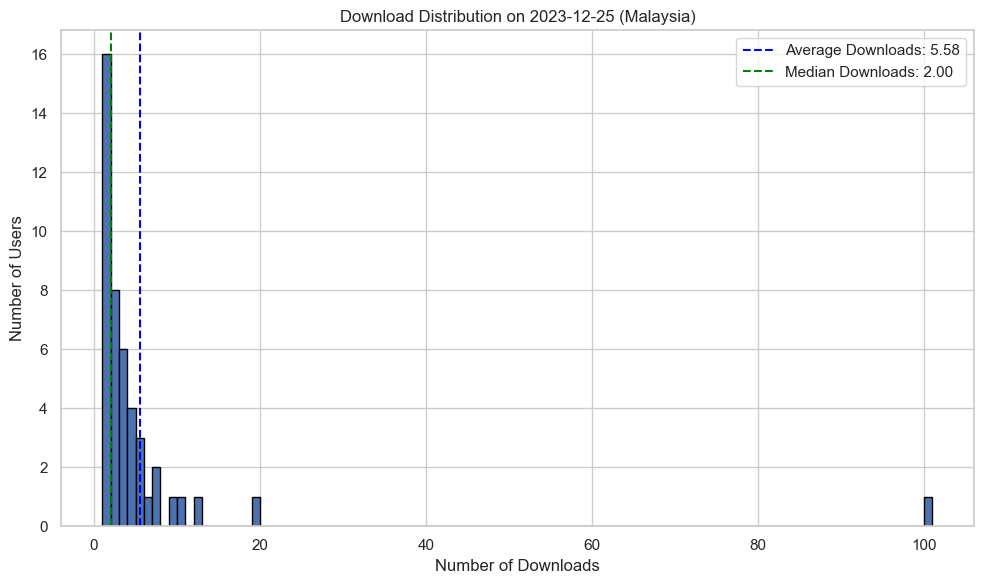

The drop occurred on a public holiday: 2023-12-25


In [67]:
holiday = '2023-12-25'
test_public_holiday_date = pd.to_datetime(holiday).date()  

malaysia_drop_data = merged_df[(merged_df['country'] == 'MY') & 
                                (merged_df['date_download'].dt.date == test_public_holiday_date)]

downloads_by_user_on_drop = malaysia_drop_data.groupby('uid').size()

downloads_by_user_on_drop = downloads_by_user_on_drop.dropna()

plt.figure(figsize=(10, 6))

if not downloads_by_user_on_drop.empty:
    max_downloads = int(downloads_by_user_on_drop.max()) 
    plt.hist(downloads_by_user_on_drop, bins=range(1, max_downloads + 2), edgecolor='black')

    plt.title(f"Download Distribution on {test_public_holiday_date} (Malaysia)")
    average_downloads = downloads_by_user_on_drop.mean()
    median_downloads = downloads_by_user_on_drop.median()
    plt.axvline(average_downloads, color='blue', linestyle='dashed', label=f"Average Downloads: {average_downloads:.2f}")
    plt.axvline(median_downloads, color='green', linestyle='dashed', label=f"Median Downloads: {median_downloads:.2f}")

    plt.xlabel("Number of Downloads")
    plt.ylabel("Number of Users")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"No data available for the public holiday: {holiday}")

is_public_holiday = test_public_holiday_date.strftime('%Y-%m-%d') in public_holidays
if is_public_holiday:
    print(f"The drop occurred on a public holiday: {test_public_holiday_date.strftime('%Y-%m-%d')}")
else:
    print(f"The drop did not occur on a public holiday: {test_public_holiday_date.strftime('%Y-%m-%d')}")

### Is the drop coming from the Malaysia market and a result of Malaysian public holidays because the CEO said he saw a drop in download count whenever there is a public holiday.

The analysis shows that download counts in Malaysia are significantly lower on public holidays, with both the average and median downloads dropping compared to regular days. This supports the CEO's observation that user engagement is reduced during holidays.

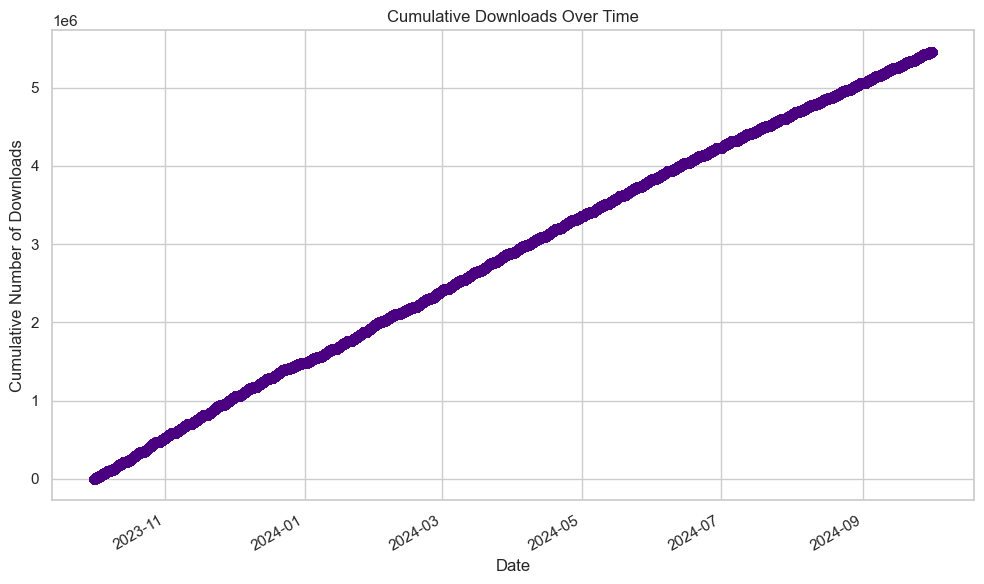

In [ ]:
cumulative_downloads = merged_df.groupby('date_download').size().cumsum()

plt.figure(figsize=(10, 6))
cumulative_downloads.plot(kind='line', color='indigo', marker='o')
plt.title("Cumulative Downloads Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Number of Downloads")
plt.grid(True)
plt.tight_layout()
plt.show()


The exponential increase in cumulative downloads shows that the number of downloads is growing rapidly, indicating strong user engagement and product demand.

Number of outliers: 1903
Outliers range: 499.00000000000006 - 498466.0000000003


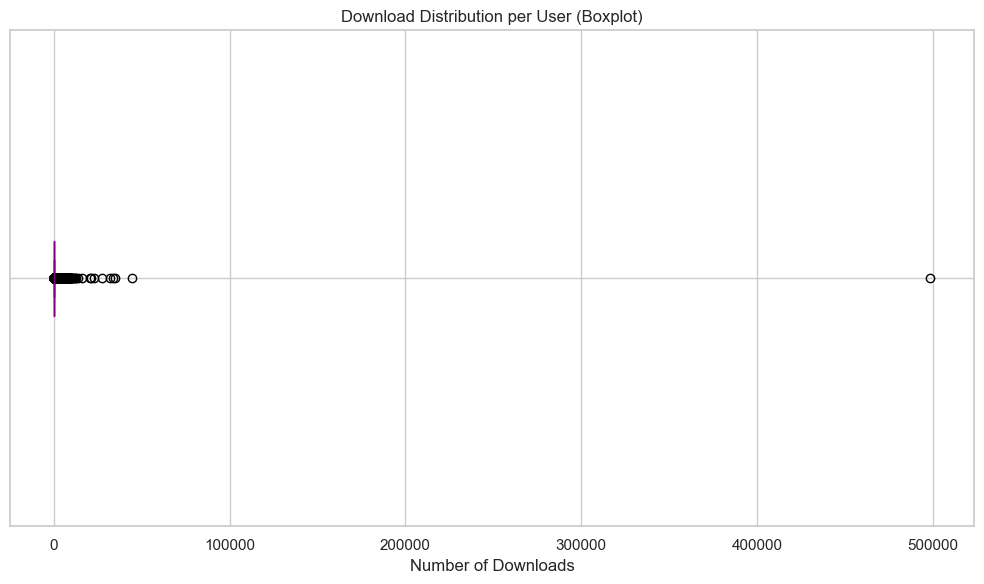

In [87]:
downloads_per_user = merged_df.groupby('uid').size()

log_downloads_per_user = downloads_per_user[downloads_per_user > 0].apply(np.log)

Q1 = log_downloads_per_user.quantile(0.25)
Q3 = log_downloads_per_user.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

log_outliers = log_downloads_per_user[(log_downloads_per_user < lower_bound) | (log_downloads_per_user > upper_bound)]

outliers = np.exp(log_outliers)

print(f"Number of outliers: {len(outliers)}")
print(f"Outliers range: {outliers.min()} - {outliers.max()}")

plt.figure(figsize=(10, 6))
downloads_per_user.plot(kind='box', vert=False, color='purple')
plt.title("Download Distribution per User (Boxplot)")
plt.xlabel("Number of Downloads")
plt.tight_layout()
plt.show()


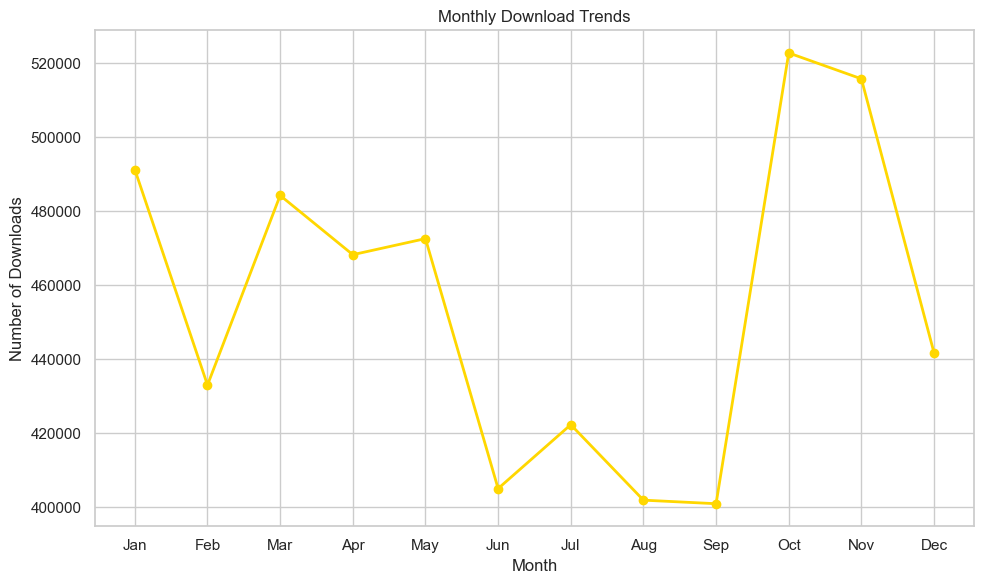

The highest number of downloads occurred in month 10, with 522777 downloads.


In [81]:
monthly_downloads = merged_df.groupby(merged_df['date_download'].dt.month).size()

plt.figure(figsize=(10, 6))
monthly_downloads.plot(kind='line', marker='o', color='gold', linestyle='-', linewidth=2)
plt.title("Monthly Download Trends")
plt.xlabel("Month")
plt.ylabel("Number of Downloads")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()

highest_month = monthly_downloads.idxmax()
highest_downloads = monthly_downloads.max()

print(f"The highest number of downloads occurred in month {highest_month}, with {highest_downloads} downloads.")



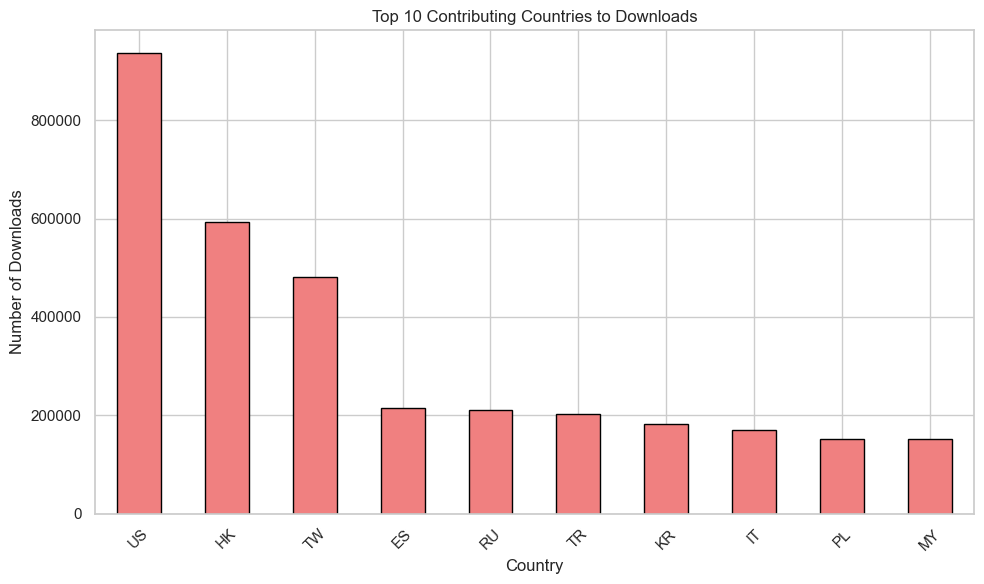

Top 10 Contributing Countries: 
 {'US': 936176, 'HK': 594072, 'TW': 481292, 'ES': 214875, 'RU': 210109, 'TR': 202372, 'KR': 181509, 'IT': 169975, 'PL': 152029, 'MY': 151487}


In [82]:
top_10_countries = merged_df['country'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_10_countries.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title("Top 10 Contributing Countries to Downloads")
plt.xlabel("Country")
plt.ylabel("Number of Downloads")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Top 10 Contributing Countries: \n", top_10_countries.to_dict())


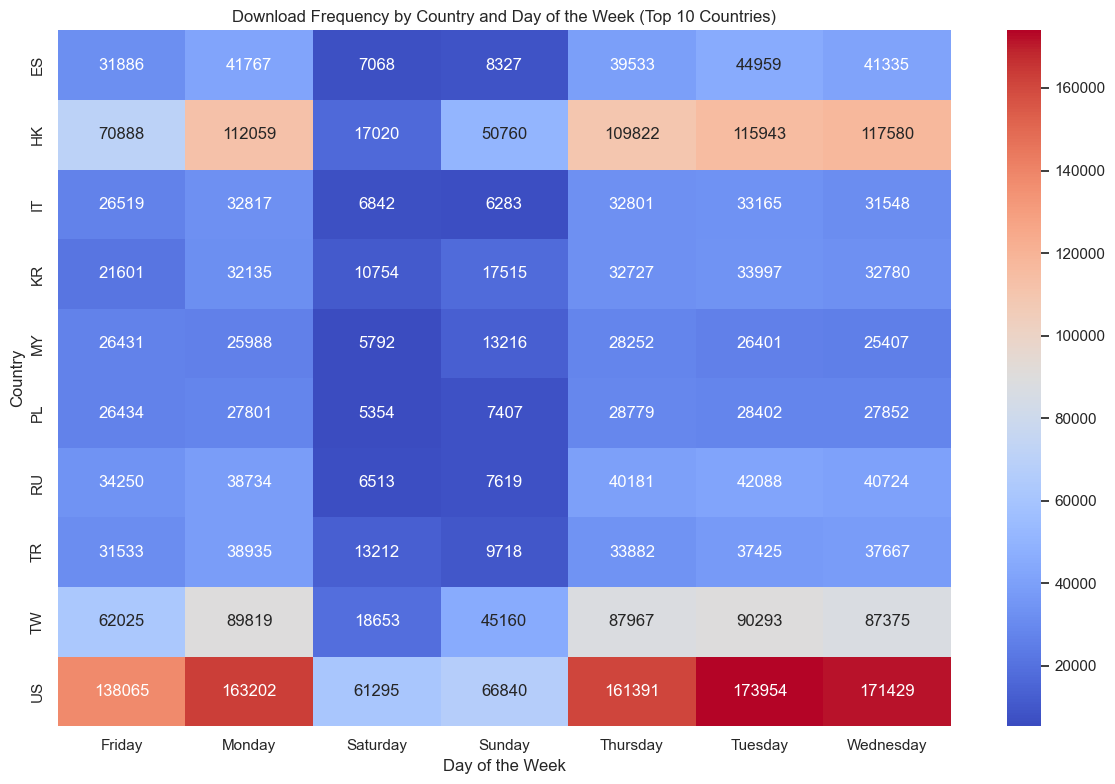

In [83]:
top_10_countries_list = top_10_countries.index.tolist()

filtered_data_top_10_countries = merged_df[merged_df['country'].isin(top_10_countries_list)]

download_freq_by_country_day = filtered_data_top_10_countries.groupby(['country', merged_df['date_download'].dt.day_name()]).size().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(download_freq_by_country_day, cmap='coolwarm', annot=True, fmt='d', cbar=True)
plt.title("Download Frequency by Country and Day of the Week (Top 10 Countries)")
plt.xlabel("Day of the Week")
plt.ylabel("Country")
plt.tight_layout()
plt.show()
